https://huggingface.co/HuggingFaceM4/Idefics3-8B-Llama3

https://bhavyajoshi809.medium.com/fine-tune-inference-of-idefics3-8b-on-custom-data-for-ocr-69e8bf61fecf

https://bhavyajoshi809.medium.com/fine-tuning-multi-model-llm-qwen2-vl-on-custom-data-for-ocr-part-2-lora-fine-tuning-qwen2-vl-aac86d631745

In [1]:
!nvidia-smi

Sun Dec 22 00:56:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:C1:00.0 Off |                  N/A |
|  0%   45C    P8             24W /  350W |      26MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

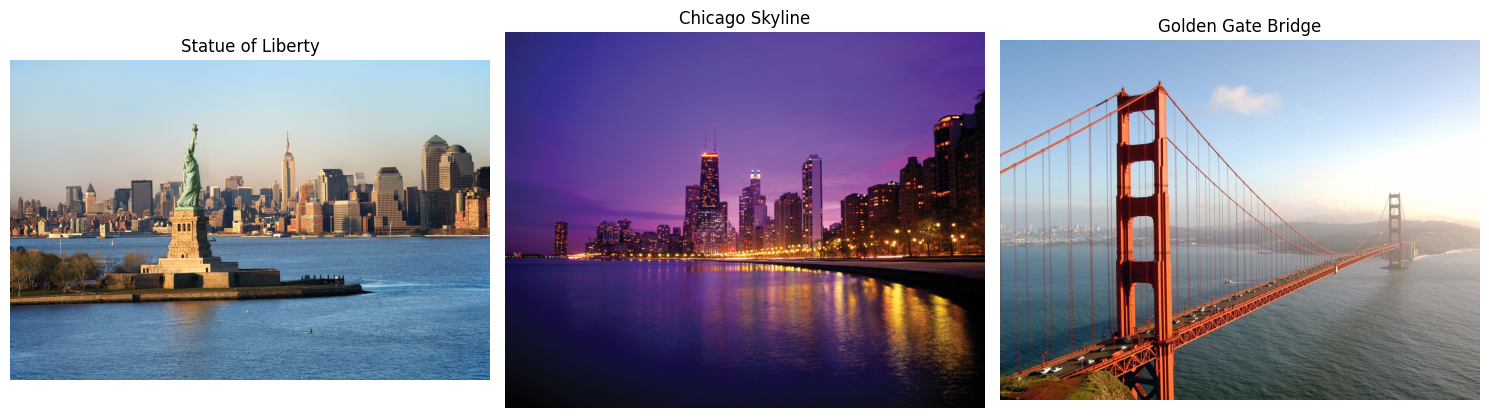

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor

# Function to load images from URLs (assuming load_image is part of your environment or defined elsewhere)
def load_image(url):
    from PIL import Image
    import requests
    from io import BytesIO
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# Load images from URLs
image1 = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
image2 = load_image("https://cdn.britannica.com/59/94459-050-DBA42467/Skyline-Chicago.jpg")
image3 = load_image("https://cdn.britannica.com/68/170868-050-8DDE8263/Golden-Gate-Bridge-San-Francisco.jpg")

# Display the images
images = [image1, image2, image3]
titles = ["Statue of Liberty", "Chicago Skyline", "Golden Gate Bridge"]

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

for idx, (image, title) in enumerate(zip(images, titles)):
    axes[idx].imshow(image)
    axes[idx].set_title(title)
    axes[idx].axis("off")  # Turn off axes for better visualization

plt.tight_layout()
plt.show()

In [4]:
import requests
import torch
from PIL import Image
from io import BytesIO

from transformers import AutoProcessor, AutoModelForVision2Seq

DEVICE = "cuda:0"


processor = AutoProcessor.from_pretrained("HuggingFaceM4/Idefics3-8B-Llama3")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceM4/Idefics3-8B-Llama3", torch_dtype=torch.bfloat16).to(DEVICE)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
    {
        "role": "assistant",
        "content": [
            {"type": "text", "text": "In this image, we can see the city of New York, and more specifically the Statue of Liberty."},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "And how about this image?"},
        ]
    },       
]


prompt = processor.apply_chat_template(messages, add_generation_prompt=True)


In [ ]:
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}


# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts)


["User:<image>What do we see in this image?\nAssistant: In this image, we can see the city of New York, and more specifically the Statue of Liberty.\nUser:<image>And how about this image?\nAssistant: The image depicts a picturesque nighttime cityscape of New York City, showcasing the iconic skyline and the Statue of Liberty. The sky is painted in a gradient of purples and blues, suggesting either a sunset or sunrise, with the colors transitioning from deep blue at the top to a lighter shade near the horizon. The lighting of the city's buildings and lights reflects off the calm waters of the Hudson River, creating a mirrored effect that enhances the beauty of the scene.\n\nIn the foreground, the Statue of Liberty stands prominently on Liberty Island, her torch held high, symbolizing freedom and democracy. The statue is illuminated, casting a golden glow that contrasts with the cooler tones of the sky. The statue's pedestal and base are visible, and the surrounding area appears to be a p

In [10]:
from IPython.display import display, HTML

# display larger front 
display(HTML(f"<p style='font-size: 16px'>{generated_texts[0]}</p>"))

In [16]:
from IPython.display import display, Markdown


# Process and display each tag
for text in generated_texts:
    lines = text.split("\n")  # Split the text into lines
    for line in lines:
        if line.startswith("User:"):
            display(Markdown(f"**User:** {line[5:]}"))
        elif line.startswith("Assistant:"):
            display(Markdown(f"**Assistant:** {line[10:]}"))


**User:** <image>What do we see in this image?

**Assistant:**  In this image, we can see the city of New York, and more specifically the Statue of Liberty.

**User:** <image>And how about this image?

**Assistant:**  The image depicts a picturesque nighttime cityscape of New York City, showcasing the iconic skyline and the Statue of Liberty. The sky is painted in a gradient of purples and blues, suggesting either a sunset or sunrise, with the colors transitioning from deep blue at the top to a lighter shade near the horizon. The lighting of the city's buildings and lights reflects off the calm waters of the Hudson River, creating a mirrored effect that enhances the beauty of the scene.

# Test Next picutre

In [17]:
# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What do we see in this image?"},
        ]
    },
]


prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

In [18]:
inputs = processor(text=prompt, images=[image3], return_tensors="pt")
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}


# Generate
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts)

["User:<image>What do we see in this image?\nAssistant: The image depicts the Golden Gate Bridge, a suspension bridge spanning the Golden Gate strait, which is the opening of San Francisco Bay into the Pacific Ocean. The bridge is a prominent landmark and a symbol of San Francisco, California. It is painted in a distinctive orange-red color and is supported by two large towers connected by a series of cables and suspender cables. The bridge is suspended by two main cables that run parallel to each other and are anchored to the towers at each end. These cables are supported by numerous suspender cables that connect them to the roadway.\n\nThe roadway of the bridge is visible, with multiple lanes for both directions of traffic. There are several vehicles on the bridge, including cars and possibly some trucks, indicating that it is a busy day. The bridge is surrounded by water on both sides, with the San Francisco Bay on the left and the Pacific Ocean on the right. The water is relatively

In [20]:
from IPython.display import display, Markdown


# Process and display each tag
for text in generated_texts:
    lines = text.split("\n")  # Split the text into lines
    for line in lines:
        if line.startswith("User:<image>"):
            display(Markdown(f"**User:** {line[5:]}"))
        elif line.startswith("Assistant:"):
            display(Markdown(f"**Assistant:** {line[10:]}"))


**User:** <image>What do we see in this image?

**Assistant:**  The image depicts the Golden Gate Bridge, a suspension bridge spanning the Golden Gate strait, which is the opening of San Francisco Bay into the Pacific Ocean. The bridge is a prominent landmark and a symbol of San Francisco, California. It is painted in a distinctive orange-red color and is supported by two large towers connected by a series of cables and suspender cables. The bridge is suspended by two main cables that run parallel to each other and are anchored to the towers at each end. These cables are supported by numerous suspender cables that connect them to the roadway.